In [1]:
import pandas as pd
import time
import numpy as np
import requests
from selenium import webdriver
from bs4 import BeautifulSoup
from selenium.webdriver.support.ui import WebDriverWait

In [2]:
df=pd.read_csv('./data/priorities_list.csv')

# Scraping address off of the site progress url

In [30]:
def extract_address(website):
    time.sleep(0.1)
    url =website
    browser = webdriver.Chrome()
    wait = WebDriverWait(browser, 10)
    browser.get(url)
    soup = BeautifulSoup(browser.page_source, "lxml")
    browser.close()
    try:
        return_str=str(soup).split('Street Address')[1].split('\n')[2].lstrip().rstrip()
    except:
        return_str='NaN'
    return return_str
df['address']=df.site_progress_url.apply(extract_address)

In [40]:
#manually correcting some missing data
#https://semspub.epa.gov/work/05/309184.pdf
df.address.iloc[344]="5300 Kennedy Avenue, Lake County, Indiana 46312"

#http://scorecard.goodguide.com/env-releases/land/site.tcl?epa_id=MAD980731335
df.address.iloc[446]='ACUSHNET ESTUARY, NEW BEDFORD, MA 02740'

/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [41]:
#resave data
df.to_json('./data/priorities_list_waddr.json')

# Geocoding
1. Will code in multiple ways in order to prevent gross errors or missing data

In [2]:
#loading google API key
with open('~/google_apikey.txt') as f:
    content = f.readlines()

google_apikey=content[0][:-1]

In [3]:
df=pd.read_json('./data/priorities_list_waddr.json')

In [4]:
#correcting one for which the parser didn't work
df.address.loc[1168]='W BANK OF SAN JACINTO RIVER, N OF HWY 10, Channelview, TX 77530'

/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [5]:
def geocode_address(row):
    address=row.address
    addr_goog='https://maps.googleapis.com/maps/api/geocode/json?address='+address.replace(' ','+')+\
            '&key='+google_apikey
    res=requests.get(addr_goog)
    try:
        row['goog_lat']=res.json()['results'][0]['geometry']['location']['lat']
        row['goog_long']=res.json()['results'][0]['geometry']['location']['lng']
    except:
        row['goog_lat']=float('NaN')
        row['goog_long']=float('NaN')
    res=requests.get('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?address='+\
             address.replace(',','%2C').replace(" ","+")+'&benchmark=9&format=json')
    try:
        row['census_long']=res.json()['result']['addressMatches'][0]['coordinates']['x']
        row['census_lat']=res.json()['result']['addressMatches'][0]['coordinates']['y']
    except:
        row['census_long']=float('NaN')
        row['census_lat']=float('NaN')
    time.sleep(0.1)
    return row
df=df.apply(geocode_address,axis=1)
df.census_lat.isnull().sum(),df.goog_lat.isnull().sum()

(1000, 241)

In [6]:
df.to_json('./data/priorities_list_waddr_geocoded.json')

In [35]:
def clean_address(row):
    latdif=abs(row.census_lat-row.goog_lat)       
    longdif=abs(row.census_long-row.goog_long)   
    if not np.isfinite(latdif) or latdif>0.1:
        address=', '.join(row.address.split(', ')[1:])
        addr_goog='https://maps.googleapis.com/maps/api/geocode/json?address='+address.replace(' ','+')+\
                '&key='+google_apikey
        res=requests.get(addr_goog)
        try:
            newlat=res.json()['results'][0]['geometry']['location']['lat']
            newlong=res.json()['results'][0]['geometry']['location']['lng']
            latdif=abs(newlat-row.goog_lat)
            longdif=abs(newlong-row.goog_long)
            distance=(latdif**2+longdif**2)**0.5
            if not np.isfinite(latdif):
                row['goog_lat']=newlat
                row['goog_long']=newlong
                row['geocode_source']='city_state_zip'
            elif distance>=1.:
                row['goog_lat']=newlat
                row['goog_long']=newlong
                row['geocode_source']='city_state_zip'
            else:
                row['geocode_source']='full_address'
        except:
            row['goog_lat']=float('NaN')
            row['goog_long']=float('NaN')
            row['geocode_source']='zip_only'
        time.sleep(.1)
    else:
        row['geocode_source']='full_address'
    return row
df2=df.apply(clean_address,axis=1)
df2.goog_lat.isnull().sum()

19

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


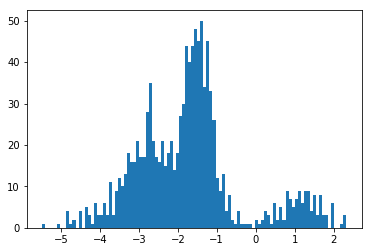

In [34]:
plt.hist(np.log10(df_test.distance)[(~df_test.distance.isnull()) & (df_test.distance!=0.)],bins=100)
plt.show()

In [37]:
#checking against zip only
def zip_only(row):
    if row.geocode_source!='full_address' and row.address!='NaN':
        address=row.address[-5:]
        addr_goog='https://maps.googleapis.com/maps/api/geocode/json?address='+address.replace(' ','+')+\
                '&key='+google_apikey
        res=requests.get(addr_goog)
        try:
            newlat=res.json()['results'][0]['geometry']['location']['lat']
            newlong=res.json()['results'][0]['geometry']['location']['lng']
            latdif=abs(newlat-row.goog_lat)
            longdif=abs(newlong-row.goog_long)
            distance=(latdif**2+longdif**2)**0.5
            if not np.isfinite(row.goog_lat):
                row['goog_lat']=newlat
                row['goog_long']=newlong
                row['geocode_source']='zip_only'
            elif distance>=1.:
                row['goog_lat']=newlat
                row['goog_long']=newlong
                row['geocode_source']='zip_only'
        except:
            row['goog_lat']=float('NaN')
            row['goog_long']=float('NaN')
            row['geocode_source']='NaN'
        time.sleep(.1)
    elif row.address=='NaN':
        row['geocode_source']='NaN'
    return row
df3=df2.apply(zip_only,axis=1)
df3.census_lat.isnull().sum(),df3.goog_lat.isnull().sum()

(1000, 5)

In [51]:
df3[(df3.goog_long>-10) & (df3.goog_lat>40)]=df3[(df3.goog_long>-10) & (df3.goog_lat>40)].apply(clean_address,axis=1)

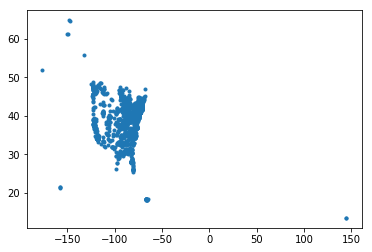

In [52]:
plt.plot(df3.goog_long,df3.goog_lat,'.')
plt.show()

In [58]:
df3.drop(['census_lat','census_long'],axis=1,inplace=True)

df3.rename(columns={'goog_lat':'latitude','goog_long':'longitude'},inplace=True)

In [61]:
def encode_fips(row):
    if np.isfinite(row.latitude):
        qstring='http://data.fcc.gov/api/block/find?format=json&latitude='+str(row.latitude)+'&longitude='\
            +str(row.longitude)
        res=requests.get(qstring)
        try:
            row['FIPS_Block_Group']=res.json()['Block']['FIPS']
        except:
            row['FIPS_Block_Group']=float('NaN')            
    else:
        row['FIPS_Block_Group']=float('NaN')
    return row
df3=df3.apply(encode_fips,axis=1)

In [63]:
df3.FIPS_Block_Group.isnull().sum()

5

In [65]:
df3.to_json('./data/priorities_list_waddr_geocoded.json')